# Image captioning with CNN + Bahdanau Attention + GRU

## Setup

In [ ]:
import os
import time
import string
import json
from PIL import Image
from tqdm import tqdm
import pickle
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from nltk.translate.bleu_score import sentence_bleu

from google.colab import files

import warnings 
warnings.filterwarnings("ignore")

## Download the Flickr8k dataset

In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

## Prepare the dataset

In [ ]:
# Path to the images
IMAGES_PATH = "./Flicker8k_Dataset/"
# Path to the token
TOKEN_PATH = "./Flickr8k.token.txt"

In [ ]:
jpgs = os.listdir(IMAGES_PATH)
print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 8091


In [ ]:
def load_captions_data(filename):
    """
    Loads captions (text) data and maps them to corresponding images.
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            img_name = img_name.split("#")[0]

            # We will remove caption that are either too short
            tokens = caption.strip().split()

            if len(tokens) < 4:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption.lower())
                else:
                    caption_mapping[img_name] = [caption.lower()]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping

In [ ]:
captions_mapping = load_captions_data(TOKEN_PATH)

In [ ]:
print('Number of samples: ', len(captions_mapping))

Number of samples:  8028


In [ ]:
train_captions = []
img_name_vector = []

for image_path in captions_mapping:
  caption_list = captions_mapping[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

In [ ]:
data = pd.DataFrame(zip(img_name_vector, train_captions), columns=["filename", "caption"])

In [ ]:
data

,filename,caption
0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...
...,...,...
40135,997722733_0cb5439472.jpg,a man in a pink shirt climbs a rock face
40136,997722733_0cb5439472.jpg,a man is rock climbing high in the air .
40137,997722733_0cb5439472.jpg,a person in a red shirt climbing up a rock fac...
40138,997722733_0cb5439472.jpg,a rock climber in a red shirt .


In [ ]:
uni_filenames = np.unique(data.filename.values)

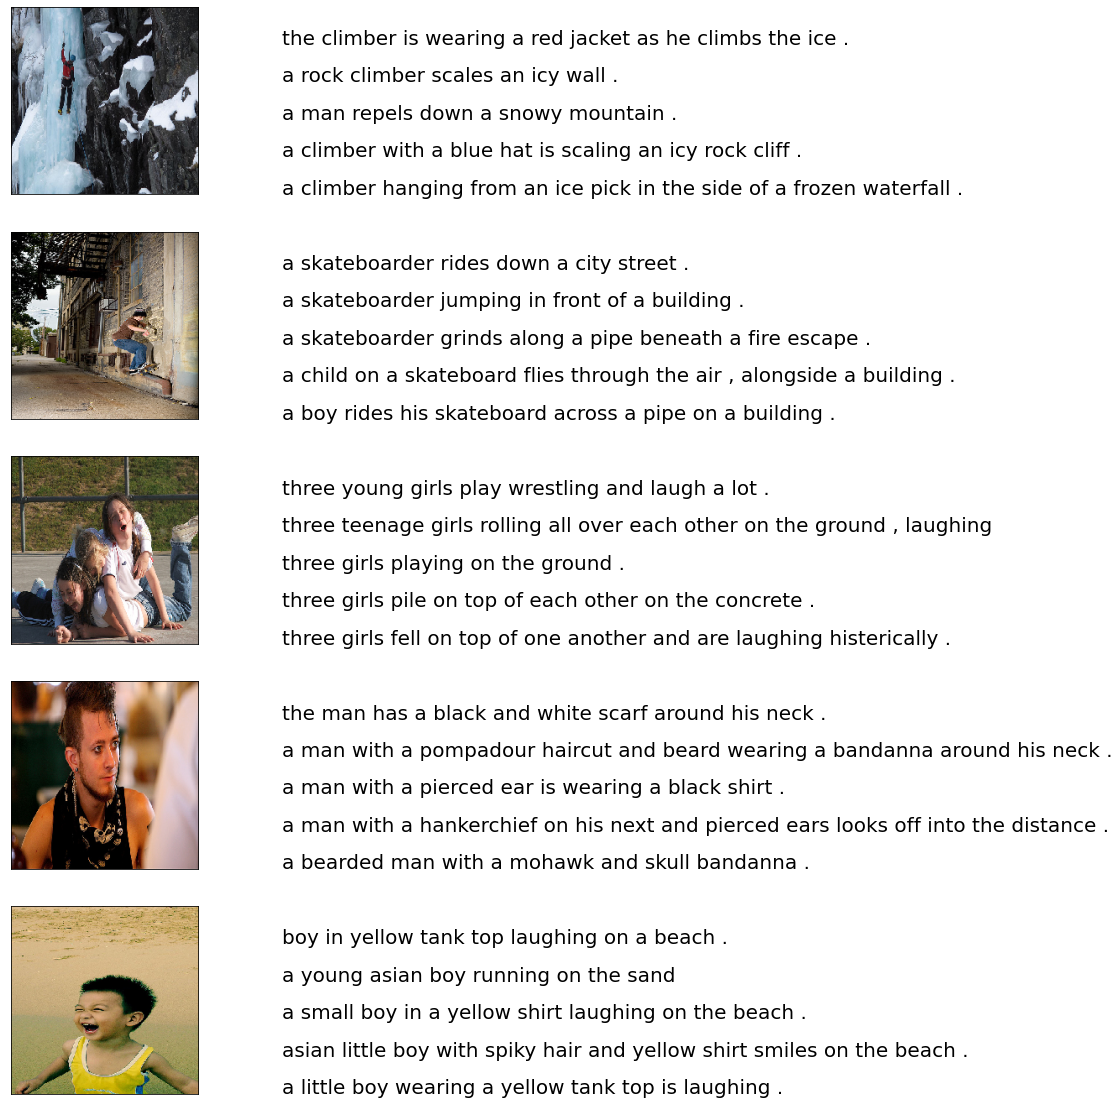

In [ ]:
npic = 5
npix = 224
target_size = (npix, npix, 3)

count = 1
fig = plt.figure(figsize=(10,20))
random_imgs = np.random.choice(uni_filenames.shape[0], 5, replace=False)
for jpgfnm in uni_filenames[random_imgs]:
    filename = IMAGES_PATH + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [ ]:
vocabulary = []
for txt in data.caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 8878


In [ ]:
def remove_punctuation(text_original):
    '''
    To remove punctuations
    '''
    text_no_punctuation = text_original.translate(string.punctuation)
    return text_no_punctuation

def remove_single_character(text):
    '''
    To remove single characters
    '''
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return text_len_more_than1

def remove_numeric(text):
    '''
    To remove numeric values
    '''
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if isalpha:
            text_no_numeric += " " + word
    return text_no_numeric

In [ ]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)
    
for i, caption in enumerate(data.caption.values):
    newcaption = text_clean(caption)
    data["caption"].iloc[i] = newcaption

In [ ]:
clean_vocabulary = []
for txt in data.caption.values:
    clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 8323


In [ ]:
all_captions = []
for caption in data["caption"].astype(str):
    caption = '<start> ' + caption+ ' <end>'
    all_captions.append(caption)

all_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [ ]:
all_img_name_vector = []
for annot in data["filename"]:
    full_image_path = IMAGES_PATH + annot
    all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['./Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 './Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 './Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 './Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 './Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 './Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 './Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 './Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 './Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 './Flicker8k_Dataset/1001773457_577c3a7d70.jpg']

In [ ]:
def data_limiter(num, total_captions, all_img_name_vector):
    train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
    train_captions = train_captions[:num]
    img_name_vector = img_name_vector[:num]
    return train_captions,img_name_vector

In [ ]:
train_captions, img_name_vector = data_limiter(40000, all_captions, all_img_name_vector)

In [ ]:
print(f"len(all_img_name_vector) : {len(img_name_vector)}")
print(f"len(all_captions) : {len(train_captions)}")

len(all_img_name_vector) : 40000
len(all_captions) : 40000


## Preprocess the images using InceptionV3

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


## Caching the features extracted from InceptionV3


In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(64)

In [ ]:
%%time
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 126/126 [01:51<00:00,  1.13it/s]

CPU times: user 2min 2s, sys: 10.2 s, total: 2min 12s
Wall time: 1min 51s


## Preprocess and tokenize the captions

In [ ]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
cap_vector.shape

(40000, 33)

In [ ]:
train_captions[:3]

['<start>  man rides his bike over rocks and creek <end>',
 '<start>  man wearing glasses and blazer stands in front of billboard sign <end>',
 '<start>  man and woman are posing for photograph in front of yellow <end>']

In [ ]:
train_seqs[:3]

[[2, 11, 131, 29, 79, 46, 206, 8, 759, 3],
 [2, 11, 21, 242, 8, 3999, 78, 4, 48, 12, 1824, 218, 3],
 [2, 11, 8, 18, 17, 190, 71, 814, 4, 48, 12, 58, 3]]

In [ ]:
max_length = cap_vector.shape[1]

In [ ]:
max_length

33

## Split the data into training and testing

In [ ]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector, cap_vector, test_size=0.2, random_state=0)

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32000, 32000, 8000, 8000)

## Create a tf.data dataset for training


In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE

features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

In [ ]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                                self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                        return_sequences=True,
                                        return_state=True,
                                        recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Training


In [ ]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0

    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
EPOCHS = 40
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Loss 1.443525
Time taken for 1 epoch 227.45 sec

Epoch 2 Loss 1.130614
Time taken for 1 epoch 168.91 sec

Epoch 3 Loss 1.021543
Time taken for 1 epoch 168.21 sec

Epoch 4 Loss 0.948924
Time taken for 1 epoch 168.10 sec

Epoch 5 Loss 0.888533
Time taken for 1 epoch 168.19 sec

Epoch 6 Loss 0.837543
Time taken for 1 epoch 168.03 sec

Epoch 7 Loss 0.790271
Time taken for 1 epoch 168.09 sec

Epoch 8 Loss 0.748092
Time taken for 1 epoch 168.48 sec

Epoch 9 Loss 0.707214
Time taken for 1 epoch 168.14 sec

Epoch 10 Loss 0.670230
Time taken for 1 epoch 168.22 sec

Epoch 11 Loss 0.633837
Time taken for 1 epoch 168.31 sec

Epoch 12 Loss 0.600186
Time taken for 1 epoch 167.97 sec

Epoch 13 Loss 0.569347
Time taken for 1 epoch 167.95 sec

Epoch 14 Loss 0.542939
Time taken for 1 epoch 168.23 sec

Epoch 15 Loss 0.514387
Time taken for 1 epoch 168.11 sec

Epoch 16 Loss 0.487372
Time taken for 1 epoch 167.91 sec

Epoch 17 Loss 0.466010
Time taken for 1 epoch 167.95 sec

Epoch 18 Loss 0.443838


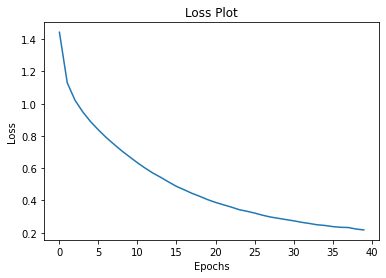

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Evaluate

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

## BLEU score

In [ ]:
image_to_captions = {}
for img, cap in zip(img_name_vector, train_captions):
    if img in image_to_captions:
        image_to_captions[img].append(cap)
    else:
        image_to_captions[img] = [cap]

Real Caption: boy sitting in car making surprised face
Predicted Caption: boy is buckled into car seat making silly face
BLEU-1 score: 44.44444444444444
BLEU-2 score: 66.66666666666666
BLEU-3 score: 78.40526816831157
BLEU-4 score: 81.6496580927726


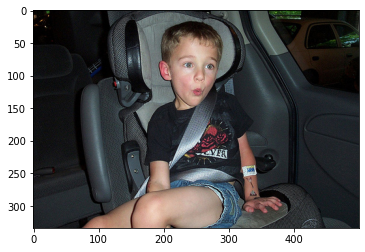

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption, attention_plot = evaluate(image)

for i in real_caption:
    if i == "<unk>":
        real_caption.remove(i)

for i in caption:
    if i == "<unk>":
        caption.remove(i)


real_caption = ' '.join(real_caption.split()[1:-1])
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

print ('Real Caption:', real_caption)
print ('Predicted Caption:', result_final)

reference = [real_caption.split()]
candidate = result_final.split()
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

## Save model

In [ ]:
encoder.save('attention_encoder')

INFO:tensorflow:Assets written to: attention_encoder/assets


In [ ]:
decoder.save('attention_decoder')

INFO:tensorflow:Assets written to: attention_decoder/assets


INFO:tensorflow:Assets written to: attention_decoder/assets


In [ ]:
!zip -r attention_encoder.zip ./attention_encoder

  adding: attention_encoder/ (stored 0%)
  adding: attention_encoder/saved_model.pb (deflated 85%)
  adding: attention_encoder/assets/ (stored 0%)
  adding: attention_encoder/variables/ (stored 0%)
  adding: attention_encoder/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: attention_encoder/variables/variables.index (deflated 31%)
  adding: attention_encoder/keras_metadata.pb (deflated 66%)


In [ ]:
!zip -r attention_decoder.zip ./attention_decoder

  adding: attention_decoder/ (stored 0%)
  adding: attention_decoder/saved_model.pb (deflated 90%)
  adding: attention_decoder/assets/ (stored 0%)
  adding: attention_decoder/variables/ (stored 0%)
  adding: attention_decoder/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: attention_decoder/variables/variables.index (deflated 55%)
  adding: attention_decoder/keras_metadata.pb (deflated 87%)


In [ ]:
with open('index_word.pickle', 'wb') as handle:
    pickle.dump(tokenizer.index_word, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('word_index.pickle', 'wb') as handle:
    pickle.dump(tokenizer.word_index, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('img_to_cap.pickle', 'wb') as handle:
    pickle.dump(image_to_captions, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('img_name_val.pickle', 'wb') as handle:
    pickle.dump(img_name_val, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('cap_val.pickle', 'wb') as handle:
    pickle.dump(cap_val, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
files.download('index_word.pickle')
files.download('word_index.pickle') 
files.download('img_to_cap.pickle')
files.download('img_name_val.pickle') 
files.download('cap_val.pickle') 
files.download('attention_decoder.zip') 
files.download('attention_encoder.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>